In [1]:
#!/usr/bin/env python3
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import IPython.display
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
#note about my change: 
#see the distribution of each of train, val, and test set values
#same so we already guarantee that - we can get more points for our gradescope if we want
#test accuracy is great!

#Pipeline:
#1Another thing to predict: rate of change of MPG, maybe how much we are accelerating
    #When velocity decreases, how fast are we decreasing by? (acceleration)

    #Bryon - 06-03
    #good idea to create a new parameter on rate of change of speed
    #rate of change of MPG as output - not sure
    #acc. = change of speed / change of time

    #Erick
    #Are we computing acceleration of samples one time step from each other (one row from each other)?
    #if we take the difference in velocity between two rows, the last row will not have a accel parameter
    #rate of change of MPG: instant fuel economy or total? difference between the two?

#have to try other models if accuracy is low - svm, etc.

#2 confusion matrix 

#3 increase training set --> [80,10,10]

#4 low number of nodes and low amount of number of hidden layers
    #A - 1 hidden layer with 5 nodes

In [3]:
#NEW: write comments?
#OLD: aggregate the data points for five files into aggregate.csv. i have removed the time predictor from the data set

# cleaned, correct dataset - elaborate on "clean" pls
files = "./data/merged.csv"

raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()

#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()

In [4]:
#To-do: consider experimenting what happens when you remove it.
#if the maxNum = 45, there are ___1788___ obs whose MPG > 45

#a function that rounds down any value above 45 to 45.
#39 is the avg highway IFE. we then choose the number 45.
#see our doc/write up for more info?
def set_max_instant_fuel_eco(dataset, max_Num):
#    count = 0
    copy = dataset.copy()
    for i in range(len(dataset.index)):
        if dataset.iloc[i, len(dataset.columns) - 1] > max_Num:
#            count += 1
            copy.iloc[i, len(dataset.columns) - 1] = max_Num
#    print(count)
    return copy
max_Num = 45
maxed_dataset = set_max_instant_fuel_eco(dataset, max_Num)
maxed_dataset.tail() #check what the data table looks like

,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG)
4855,19.60784,11.76471,59.0,29.8254,33.72549,924.2921,185.0,560.25,74.5098,443.8155,0.994239,86.0,12.40264,-1.5625,0.129654,0.0,0.095216,0.0
4856,19.60784,11.37255,59.0,29.8254,33.72549,918.3861,185.0,560.00,74.5098,443.8155,0.994239,86.0,12.40264,-1.5625,0.244755,0.0,0.163490,0.0
4857,19.60784,11.37255,59.0,29.8254,33.33333,903.6210,185.0,611.00,74.5098,439.4644,0.994239,86.0,11.81204,-1.5625,0.264600,0.0,0.176746,0.0
4858,18.43137,12.94118,59.0,29.8254,40.78431,1328.8540,185.0,686.50,74.5098,617.8608,0.994239,86.0,13.58385,-1.5625,0.269892,0.0,0.180281,0.0
4859,24.31373,12.54902,59.0,29.8254,40.00000,1154.6270,185.0,712.25,74.5098,558.3953,0.994239,86.0,14.17445,-1.5625,0.367794,0.0,0.245677,0.0


In [5]:
#sns.distplot(maxed_dataset['Vehicle speed (MPH)']);

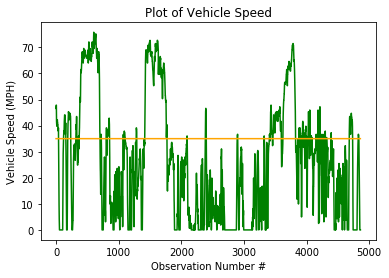

In [6]:
set35 = np.full(4859, 35)
set35
plt.plot(maxed_dataset['Vehicle speed (MPH)'], color='g')
plt.plot(set35, color='orange')
plt.xlabel('Observation Number #')
plt.ylabel('Vehicle Speed (MPH)')
plt.title('Plot of Vehicle Speed')
plt.figure(figsize=(36, 32))
plt.show()

In [7]:
#dataset.iloc[:, len(dataset.columns) - 3] #yes - way to access speed

#a function that counts how many data points are that whose speed is more than 35 
#(meaning that the car is in the highway)

#def find_highway_speed(dataset, max_num):
#    count = 0
#    copy = dataset.copy()
#    array_speed = []
#    for i in range(len(dataset.index)):
#        if dataset.iloc[i, len(dataset.columns) - 3] > max_num:
#            count += 1
#            array_speed.append(i)
#    print(count)
#    return array_speed

#list_highway_speed = find_highway_speed(maxed_dataset, 35)

#for i in range(1,len(list_highway_speed))):
#    print(list_highway_speed[i])

#for i in range(1,len(list_highway_speed))):
#    highway_speed_dataset = maxed_dataset[list_highway_speed[i]]


In [8]:
%%time 
#set seed here!

# Bugs to fix: split evenly driving on the high way vs city (look at speed for this)
# Split evenly the data amongst the datasets

#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(88)
train, validate, test = train_validate_test_split(maxed_dataset)

train_labels = train.pop("Instant fuel economy (MPG)")
validate_labels = validate.pop("Instant fuel economy (MPG)")
test_labels = test.pop("Instant fuel economy (MPG)")

CPU times: user 22.1 ms, sys: 9.2 ms, total: 31.3 ms
Wall time: 7.7 ms


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


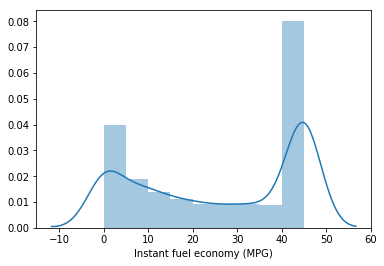

In [9]:
sns.distplot(train_labels)

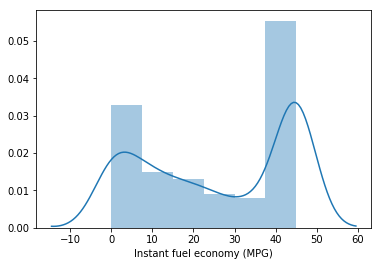

In [10]:
sns.distplot(validate_labels)

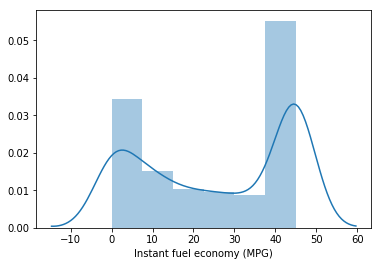

In [11]:
sns.distplot(test_labels)

In [12]:
#train.dtypes

In [13]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))

# train_stats is a pandas data frame type
train_stats = train.describe(include = 'all')
train_stats

train_stats['Vehicle speed (MPH)']

count    2916.000000
mean       26.445353
std        22.068445
min         0.000000
25%         6.213712
50%        24.233480
75%        39.146390
max        75.807290
Name: Vehicle speed (MPH), dtype: float64

In [14]:
train_stats['Vehicle speed (MPH)'][1] #mean

26.445353375514326

In [15]:
%%time 

#we have to normalize test and validation data set by using the mean and sd from training data set

# Even if we make our own, the values are similar but not exact. mine vs their mean and var
# issue: i am copying the set, find better way to not copy huge set
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean

def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var

# Normalize function from sklearn was buggy so we wrote our own
# Given a data set, normalize it and return the normalized data set
def normalizeSet(set):
    numRow = len(set.index)
    numCol = len(set.columns)
#     normed_set = set
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)        
#         normalize each each value in a particular feature 
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             normed_set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
#             print(set.iloc[row, col])
    return set
normed_train = normalizeSet(train)
normed_validate = normalizeSet(validate)
normed_test = normalizeSet(test)

CPU times: user 15.2 s, sys: 11.1 ms, total: 15.2 s
Wall time: 15.2 s


In [16]:
#https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
#this method normalizes it according to the mean and sd from each set instead of 
#normalizaing from training set only# scaler = StandardScaler()

# normed_train = scaler.fit_transform(train)
# normed_validate = scaler.fit_transform(validate)
# normed_test = scaler.fit_transform(test)



In [35]:
# build models with different number of activation layers and number of nodes to explore
# which one has lowest testing error
def build_model_A():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model


def build_model_B():
  model = keras.Sequential([
    layers.Dense(15, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(10, activation=tf.nn.relu),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

# example of comments from my 230
# 250/200/200 got us 72%/57% on noisy data with 2.5 hours per speaker
# 350/200/200/100 got us 73%/63% on noisy data with 5 hours per speaker
# So making the network bigger didn't really help much.
def build_model_C():
  model = keras.Sequential([
    layers.Dense(15, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(10, activation=tf.nn.relu),
    layers.Dense(5, activation=tf.nn.relu),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model



In [36]:
%%time
model_A = build_model_A()
model_A.summary()
model_B = build_model_B()
model_B.summary()
model_C = build_model_C()
model_C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 5)                 90        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 6         
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 15)                270       
_________________________________________________________________
dense_27 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 11        
Total params: 441
Trainable params: 441
Non-trainable params: 0
________________

In [19]:
%%time
# Also buggy: 

#change batch size? try early stop - The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history_object = model.fit(train, train_labels, epochs=100, verbose=2,
#         validation_data=(validate, validate_labels), callbacks=[early_stop])

history_object_A = model_A.fit(normed_train, train_labels, epochs=250, verbose=0,
         validation_data=(normed_validate, validate_labels))

Instructions for updating:
Use tf.cast instead.
CPU times: user 33.9 s, sys: 9.62 s, total: 43.5 s
Wall time: 21 s


In [20]:
%%time
# See where the error jumps on a particular example (maybe jumps when on high way or city)
history_object_B = model_B.fit(normed_train, train_labels, epochs=250, verbose=0,
         validation_data=(normed_validate, validate_labels))

CPU times: user 44.9 s, sys: 14.8 s, total: 59.7 s
Wall time: 26.4 s


In [37]:
%%time
# See where the error jumps on a particular example (maybe jumps when on high way or city)
history_object_C = model_C.fit(normed_train, train_labels, epochs=250, verbose=0,
         validation_data=(normed_validate, validate_labels))

CPU times: user 45.4 s, sys: 14.2 s, total: 59.6 s
Wall time: 27.5 s


In [21]:
hist_A = pd.DataFrame(history_object_A.history)
hist_A['epoch'] = history_object_A.epoch
hist_A.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
245,12.234721,2.486285,12.234718,11.877080,2.468826,11.877081,245
246,12.195864,2.480271,12.195863,11.913593,2.488812,11.913591,246
247,12.186328,2.476043,12.186327,11.849239,2.460078,11.849238,247
248,12.154282,2.469707,12.154281,11.696173,2.446876,11.696174,248
249,12.126996,2.463784,12.126997,11.705816,2.445721,11.705815,249


In [22]:
hist_B = pd.DataFrame(history_object_B.history)
hist_B['epoch'] = history_object_B.epoch
hist_B.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
245,1.410579,0.762577,1.410579,4.580906,1.047420,4.580906,245
246,1.377511,0.745552,1.377511,3.796532,1.007687,3.796531,246
247,1.384167,0.740600,1.384168,4.054502,0.892729,4.054502,247
248,1.340257,0.745355,1.340257,4.019550,0.950508,4.019549,248
249,1.493725,0.755956,1.493725,3.803321,0.819453,3.803321,249


In [38]:
hist_C = pd.DataFrame(history_object_C.history)
hist_C['epoch'] = history_object_C.epoch
hist_C.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
245,0.670710,0.535833,0.670710,3.705482,0.955195,3.705482,245
246,0.716096,0.529364,0.716096,3.758142,0.975171,3.758142,246
247,0.693716,0.531014,0.693716,3.363619,0.611401,3.363619,247
248,0.672549,0.522840,0.672549,4.317245,0.890372,4.317245,248
249,0.717246,0.536508,0.717246,3.381564,0.767451,3.381564,249


In [39]:
# For these plots, our error is super low. There might be bugs because of the way we normalize
# TODO: Fix normalization

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.xlim([0,250])
  plt.ylim([0,10])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.xlim([0,250])
  plt.ylim([0,100])
  plt.legend()
  plt.show()

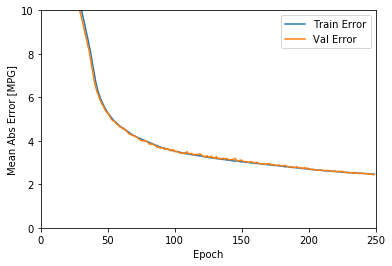

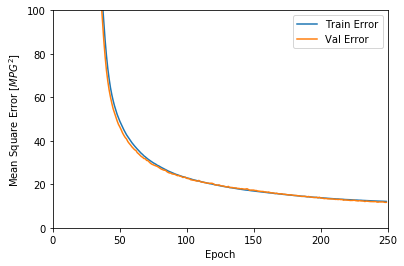

In [40]:
plot_history(history_object_A)

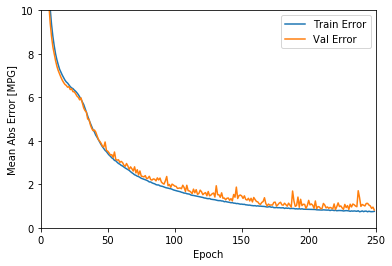

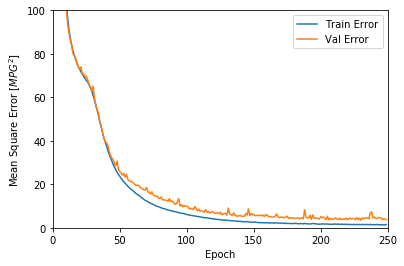

In [41]:
plot_history(history_object_B)

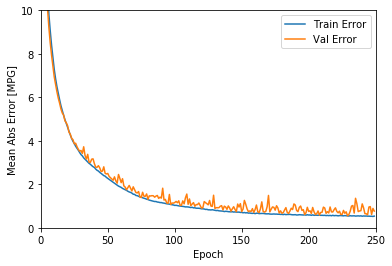

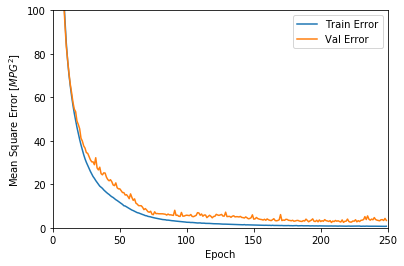

In [42]:
plot_history(history_object_C)

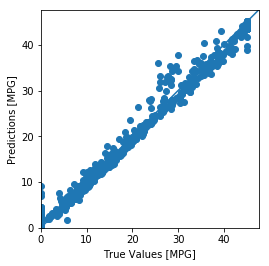

In [43]:
test_predictions = model_C.predict(normed_test).flatten()
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

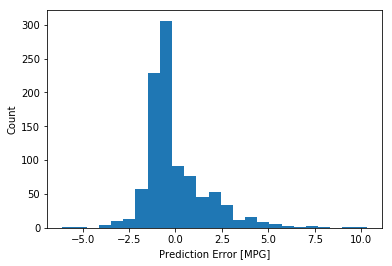

In [44]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [51]:
#https://sciencenotes.org/calculate-percent-error/
difference = abs(test_predictions - test_labels)
#difference
error = difference / test_labels
#note that when I print unprocessed_error_percentage, it shows inf value. this is from dividing by 0 from the actual 
#test values that are 0 sometimes. 
unprocessed_error_percentage = error * 100
np_error = np.array(unprocessed_error_percentage)
a = np.ma.masked_invalid(np_error)
error_percentage = a.sum() / (len(unprocessed_error_percentage) - np.count_nonzero(np.isinf(unprocessed_error_percentage)))
error_percentage

5.272769177718945

In [53]:
accuracy = 100 - error_percentage
accuracy

94.72723082228106

In [29]:
test_predictions

array([ 4.48576050e+01,  4.52369232e+01,  3.61552572e+00,  3.27657318e+01,
        4.46039352e+01,  5.12351942e+00,  4.42458763e+01,  4.13176003e+01,
        4.48144569e+01,  1.99545443e+00,  1.62736094e+00,  2.02614899e+01,
        4.50001564e+01,  4.49663887e+01,  1.06400645e+00,  3.20921822e+01,
        3.36537514e+01,  1.85434399e+01,  3.99270515e+01,  5.48335886e+00,
        4.61473198e+01,  3.48755608e+01,  5.04506445e+00,  3.70200109e+00,
        3.14785023e+01,  3.29485588e+01,  1.10041027e+01,  2.89937992e+01,
        4.48840485e+01,  4.22321510e+01,  4.49383774e+01,  4.51871796e+01,
        4.53259811e+01,  4.36398048e+01,  4.44077301e+01,  3.08966675e+01,
        5.55121756e+00,  6.06083822e+00,  4.47468567e+01,  2.55896416e+01,
        4.50317039e+01,  4.02518120e+01,  4.53088303e+01,  2.24163799e+01,
        4.51530991e+01,  5.46422148e+00,  1.47541237e+01,  4.50207939e+01,
        3.93501167e+01,  4.71353173e-01,  2.47391453e+01,  2.11476173e+01,
        3.13315725e+00,  

In [30]:
test_labels

3416    45.000000
3812    45.000000
3070     0.000000
2387    32.601070
3784    45.000000
3850     5.123758
3439    45.000000
123     43.658130
4089    45.000000
3047     0.000000
3282     0.000000
2516    14.104080
1715    45.000000
2948    45.000000
4795     0.000000
3246    29.569940
3374    27.626910
2045    20.024660
1590    41.178230
4418     6.219352
20      45.000000
593     36.673190
2874     0.000000
2876     0.000000
3957    31.553920
993     28.147510
1296    11.834980
4366    28.768630
586     45.000000
47      45.000000
          ...    
60       0.000000
1743    45.000000
1474    45.000000
2454    45.000000
4232    45.000000
4830    45.000000
1594    45.000000
4095    45.000000
2529    35.580990
2533    27.880390
1442    45.000000
4285    33.105730
3150     8.649643
1918     0.000000
2257    29.978170
2717     0.000000
2515    11.819040
1789    12.020390
1611    23.154220
3463    17.797440
3992    15.446910
3805    45.000000
964      4.640251
158     45.000000
3791    45